In [89]:

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pandas as pd
df = pd.read_csv("Chest_xray_Corona_Metadata.csv")
df

Unnamed: 0            X_ray_image_name     Label Dataset_type  \
0              0           IM-0128-0001.jpeg    Normal        TRAIN   
1              1           IM-0127-0001.jpeg    Normal        TRAIN   
2              2           IM-0125-0001.jpeg    Normal        TRAIN   
3              3           IM-0122-0001.jpeg    Normal        TRAIN   
4              4           IM-0119-0001.jpeg    Normal        TRAIN   
...          ...                         ...       ...          ...   
5905        5928  person1637_virus_2834.jpeg  Pnemonia         TEST   
5906        5929  person1635_virus_2831.jpeg  Pnemonia         TEST   
5907        5930  person1634_virus_2830.jpeg  Pnemonia         TEST   
5908        5931  person1633_virus_2829.jpeg  Pnemonia         TEST   
5909        5932  person1632_virus_2827.jpeg  Pnemonia         TEST   

     Label_2_Virus_category Label_1_Virus_category  
0                       NaN                    NaN  
1                       NaN                    NaN  
2                       NaN                    NaN  
3                       NaN                    NaN  
4                       NaN                    NaN  
...                     ...                    ...  
5905                    NaN                  Virus  
5906                    NaN                  Virus  
5907                    NaN                  Virus  
5908                    NaN                  Virus  
5909                    NaN                  Virus  

[5910 rows x 6 columns]

In [3]:
df.Label.value_counts()

Label
Pnemonia    4334
Normal      1576
Name: count, dtype: int64

In [4]:
df.Label_1_Virus_category.value_counts()

Label_1_Virus_category
bacteria          2777
Virus             1555
Stress-Smoking       2
Name: count, dtype: int64

In [5]:
import os
current_directory = os.getcwd()
data_folder = "data"
normal_folder = os.path.join(data_folder,"normal")
pneumonia_folder = os.path.join(data_folder,"pneumonia")


for folder in [data_folder,normal_folder,pneumonia_folder]:
    
        os.makedirs(folder,exist_ok=True)

In [ ]:
for index, row in df.iterrows():
    image_name = row["X_ray_image_name"]
    label = row["Label"]

    source = os.path.join("")

main_corona_train = os.path.join("Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\\train")
main_corona_test = os.path.join("Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\\test")



In [ ]:
import shutil
for index, row in df.iterrows():
    image_name = row['X_ray_image_name']
    label = row['Label']

    if row["Dataset_type"] == "TRAIN":

        source_path = os.path.join(main_corona_train, image_name)
    else:
        source_path = os.path.join(main_corona_test, image_name)
 
    if label == "Normal":
        destination_path = os.path.join(normal_folder, image_name)
    elif label == 'Pnemonia':  # Assuming this is the correct spelling
        destination_path = os.path.join(pneumonia_folder, image_name)

    shutil.copyfile(source_path, destination_path)


In [7]:
import pathlib
data_dir = pathlib.Path("data")
data_dir

WindowsPath('data')

In [8]:
train_dataset = keras.utils.image_dataset_from_directory(
    data_dir,
   
    label_mode="categorical",
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=123,  # For reproducibility
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="training"
)

# Use image_dataset_from_directory to load the dataset for validation
val_dataset = keras.utils.image_dataset_from_directory(
    data_dir,
    
    label_mode="categorical",
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=123,  # Use the same seed for consistency
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="validation"
)

Found 5910 files belonging to 2 classes.
Using 4728 files for training.
Found 5910 files belonging to 2 classes.
Using 1182 files for validation.


In [13]:
class_names = train_dataset.class_names
print(class_names)

['normal', 'pneumonia']


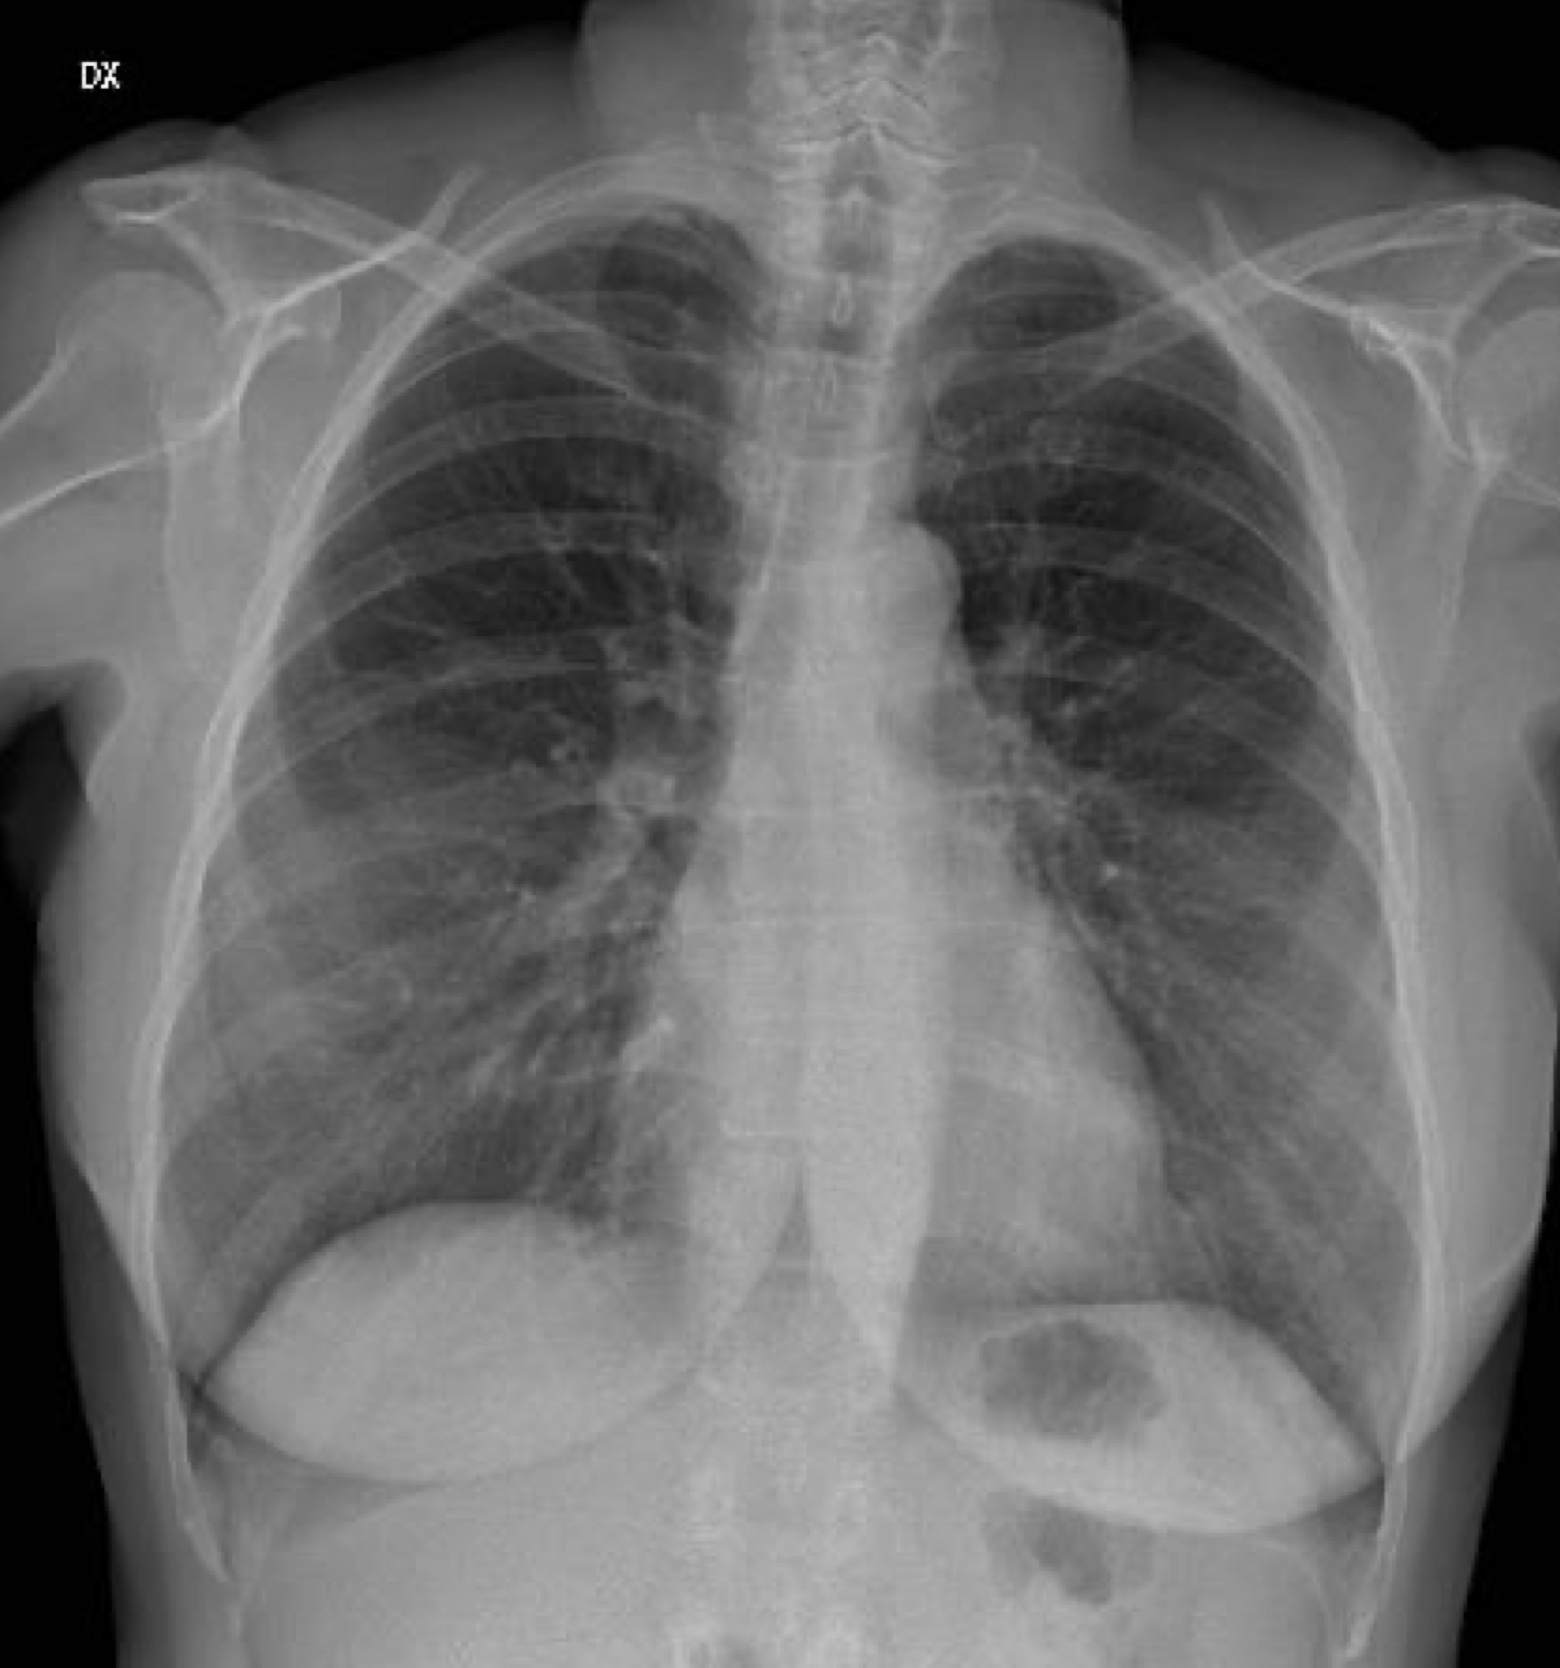

In [10]:
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[0]))

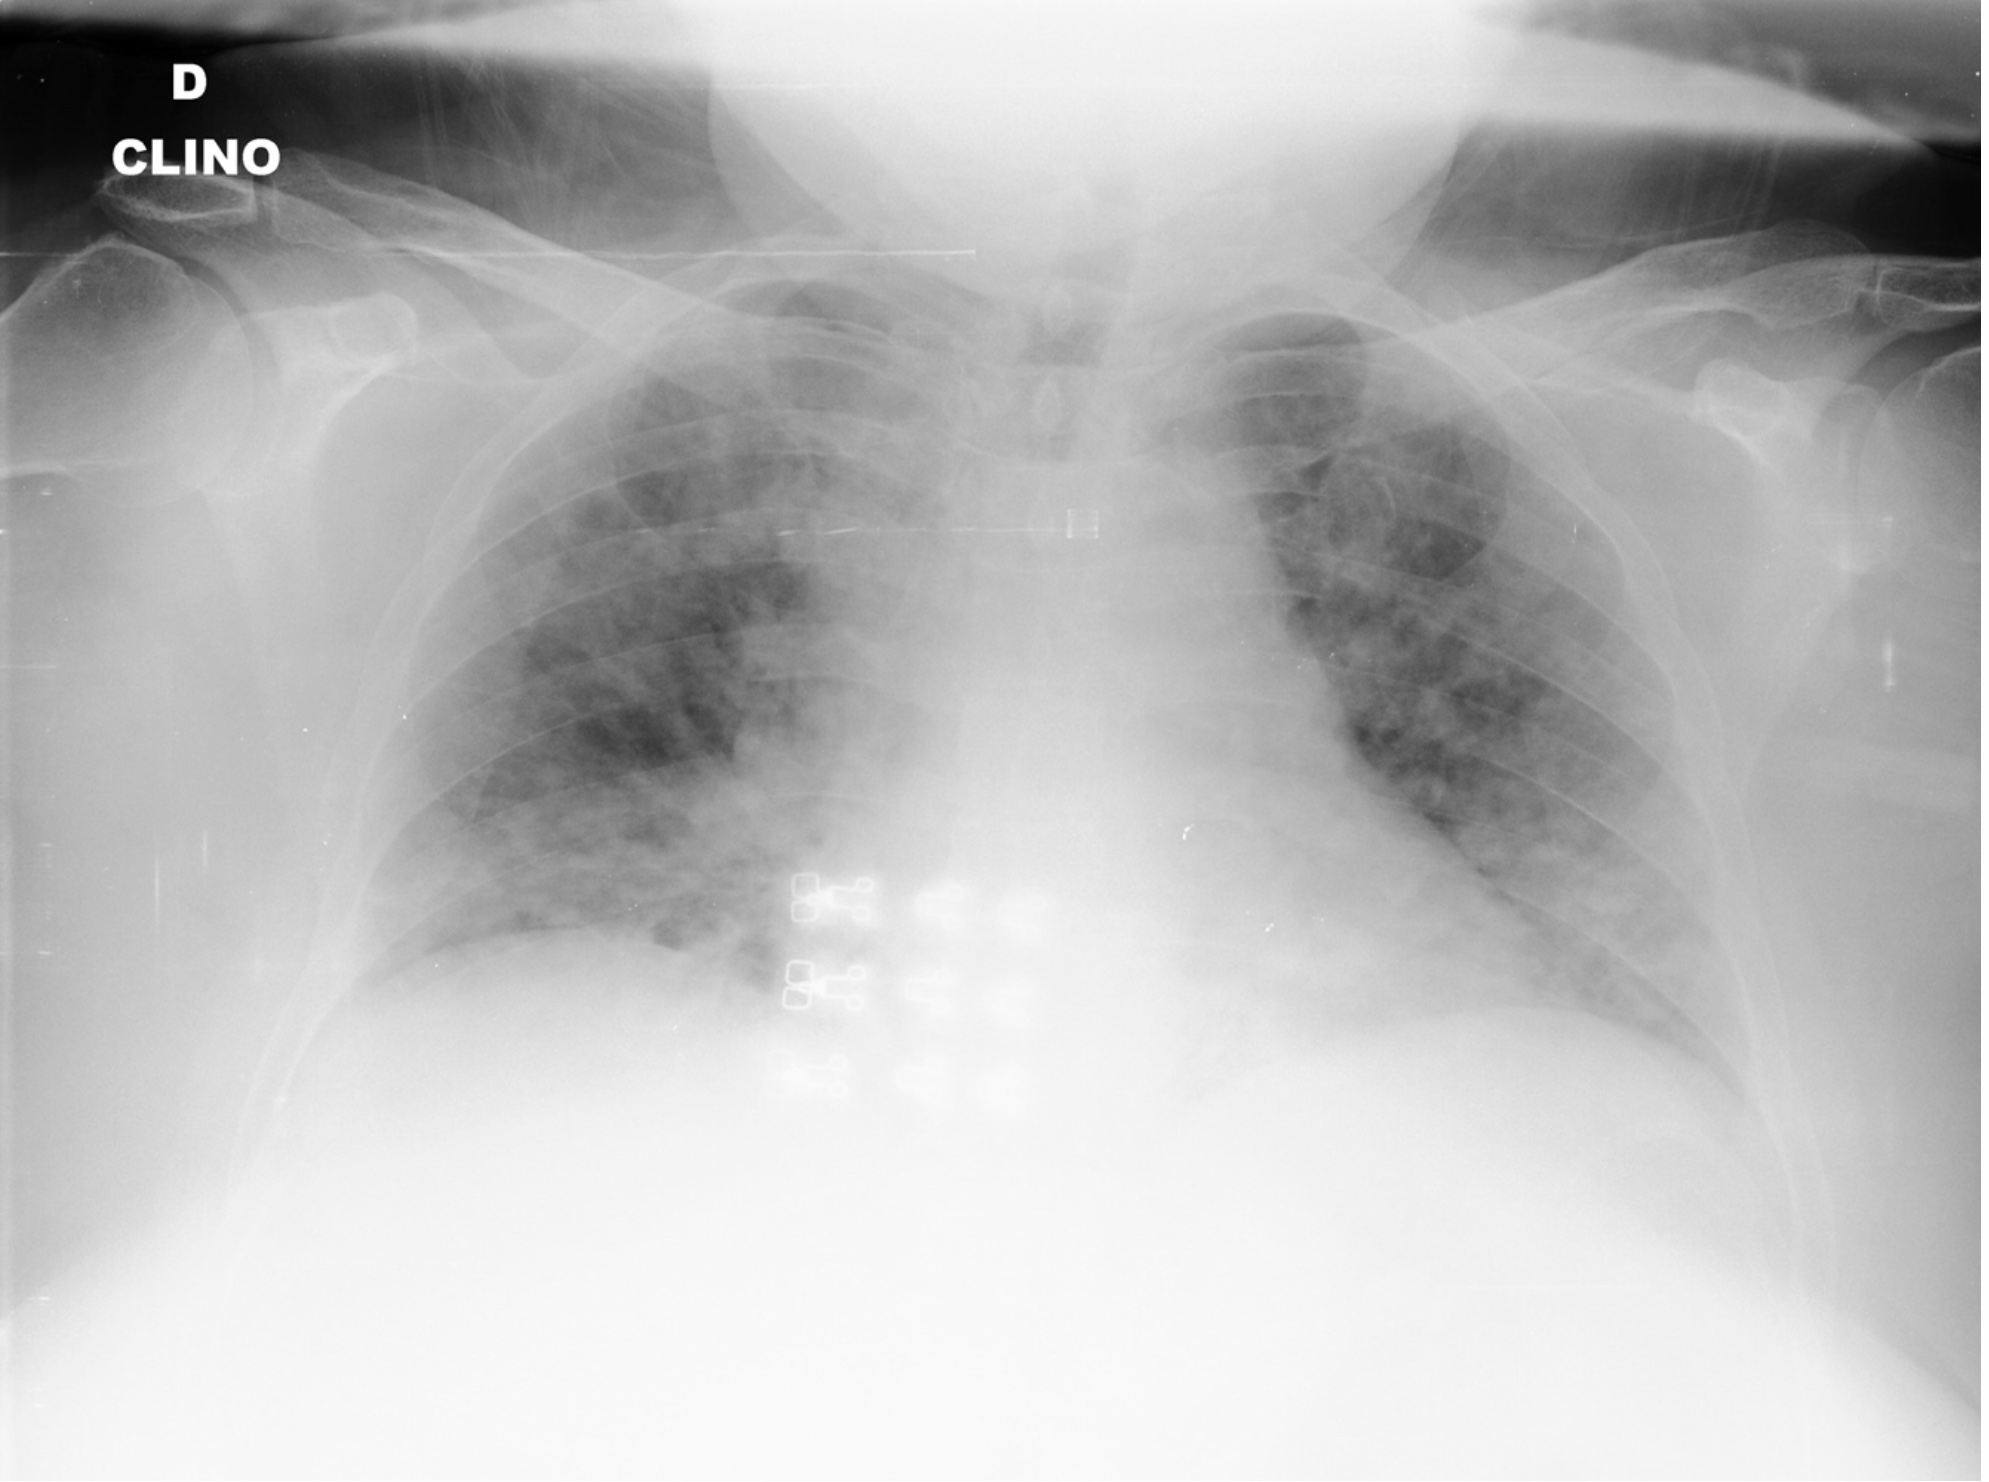

In [11]:
pneumonia = list(data_dir.glob('pneumonia/*'))
PIL.Image.open(str(pneumonia[0]))

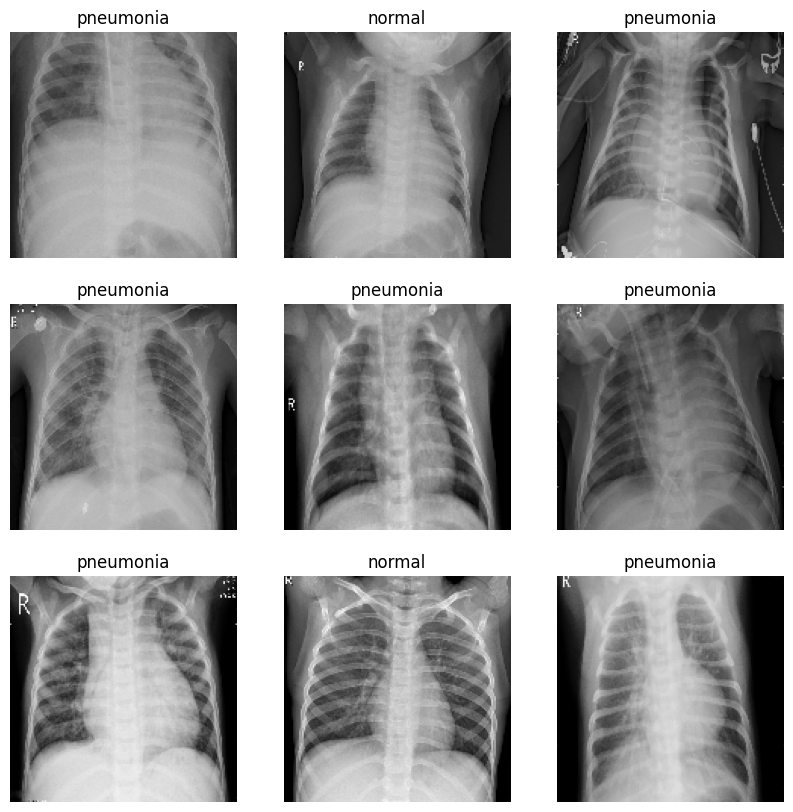

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [48]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32, 2)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [53]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.000993796 0.9939608


In [51]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [59]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", 
                          ),
       
        layers.RandomRotation(0.1),
      
        
      
        layers.RandomZoom(0.1),
       

        layers.RandomContrast(0.2),
    ]
)


In [90]:

num_classes = 2

model = tf.keras.Sequential([
    data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [91]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [92]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

148/148 [==============================] - 46s 259ms/step - loss: 0.4305 - accuracy: 0.8041 - val_loss: 0.3489 - val_accuracy: 0.8393
Epoch 2/5
148/148 [==============================] - 38s 259ms/step - loss: 0.2713 - accuracy: 0.8841 - val_loss: 0.4351 - val_accuracy: 0.8088
Epoch 3/5
148/148 [==============================] - 37s 252ms/step - loss: 0.2352 - accuracy: 0.9012 - val_loss: 0.2611 - val_accuracy: 0.8900
Epoch 4/5
148/148 [==============================] - 38s 254ms/step - loss: 0.2147 - accuracy: 0.9154 - val_loss: 0.2331 - val_accuracy: 0.9120
Epoch 5/5
148/148 [==============================] - 38s 255ms/step - loss: 0.1979 - accuracy: 0.9247 - val_loss: 0.2408 - val_accuracy: 0.9027


In [75]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

num_classes = 2

base_model = VGG16(include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  

model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(150, 150, 3)),
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes)
])

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_2.h5', monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=5, 
                    callbacks=[early_stopping, model_checkpoint])

if max(history.history['val_accuracy']) > 0.95:
    model = tf.keras.models.load_model('best_model_2.h5')

model.summary()

Epoch 1/5
148/148 [==============================] - 16s 99ms/step - loss: 9.7248 - accuracy: 0.8325 - val_loss: 8.1633 - val_accuracy: 0.8782
Epoch 2/5
148/148 [==============================] - 14s 94ms/step - loss: 7.1403 - accuracy: 0.9107 - val_loss: 6.4435 - val_accuracy: 0.9459
Epoch 3/5
148/148 [==============================] - 14s 94ms/step - loss: 5.9730 - accuracy: 0.9397 - val_loss: 5.5404 - val_accuracy: 0.9501
Epoch 4/5
148/148 [==============================] - 14s 94ms/step - loss: 5.1798 - accuracy: 0.9501 - val_loss: 4.8680 - val_accuracy: 0.9560
Epoch 5/5
148/148 [==============================] - 14s 95ms/step - loss: 4.5583 - accuracy: 0.9583 - val_loss: 4.2960 - val_accuracy: 0.9602
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 

In [73]:


base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=5,
                         callbacks=[early_stopping, model_checkpoint])

if max(history_fine.history['val_accuracy']) > 0.95:
    model = tf.keras.models.load_model('best_model.h5')

model.summary()


Epoch 1/5
148/148 [==============================] - 16s 100ms/step - loss: 4.3900 - accuracy: 0.9628 - val_loss: 4.3060 - val_accuracy: 0.9636
Epoch 2/5
148/148 [==============================] - 14s 94ms/step - loss: 4.2111 - accuracy: 0.9647 - val_loss: 4.1446 - val_accuracy: 0.9619
Epoch 3/5
148/148 [==============================] - 14s 97ms/step - loss: 4.0609 - accuracy: 0.9640 - val_loss: 4.0031 - val_accuracy: 0.9611
Epoch 4/5
148/148 [==============================] - 14s 97ms/step - loss: 3.9374 - accuracy: 0.9636 - val_loss: 3.8871 - val_accuracy: 0.9619
Epoch 5/5
148/148 [==============================] - 14s 97ms/step - loss: 3.8155 - accuracy: 0.9700 - val_loss: 3.7792 - val_accuracy: 0.9628
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                

In [95]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from kerastuner import HyperModel, RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class MyHyperModel(HyperModel):
    def build(self, hp):
        base_model = VGG16(include_top=False, input_shape=(150, 150, 3))
        base_model.trainable = False
        
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(150, 150, 3)))
        model.add(base_model)
        model.add(Flatten())

        # Tune the number of dense layers
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
                            activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)))
            model.add(BatchNormalization())
            model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.3, max_value=0.7, step=0.1)))

        model.add(Dense(num_classes))

        # Tune the optimizer
        optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=hp.Float('adam_learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG'))
        else:
            optimizer = RMSprop(learning_rate=hp.Float('rmsprop_learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG'))
        
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        
        return model

# Define the tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='tuning'
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')


tuner.search(train_ds, validation_data=val_ds, epochs=5, callbacks=[early_stopping])

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 10 Complete [00h 02m 25s]
val_accuracy: 0.9564297795295715

Best val_accuracy So Far: 0.9623519480228424
Total elapsed time: 00h 19m 55s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                             